In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE =42
np.random.seed(RANDOM_STATE)

user_feats = pd.read_csv("../intermediate/user_features.csv")

print("Shape", user_feats.shape)
display(user_feats.head())
print("\nData Typse:\n",user_feats.dtypes)
print("\n Missing Values:\n", user_feats.isna().sum())




Shape (2000, 22)


,user_id,age,income,experience_years,risk_survey_score,total_transactions,avg_amount,first_tx_date,last_tx_date,active_days,...,pct_crypto,pct_etf,pct_forex,pct_other,pct_stocks,pct_bond,volatility_mean_30,volatility_mean_60,volatility_std_30,risk_level
0,1,42,242,11,17,9,847.520000,2021-06-08,2024-08-13,1162,...,0.444444,0.000000,0.0,0.111111,0.444444,0.0,0.016283,0.016300,0.006089,medium
1,2,36,332,4,17,10,906.072000,2020-01-10,2024-10-10,1735,...,0.500000,0.100000,0.0,0.000000,0.400000,0.0,0.013613,0.013644,0.004067,medium
2,3,44,225,20,11,11,678.171818,2020-06-26,2024-04-20,1394,...,0.636364,0.090909,0.0,0.181818,0.090909,0.0,0.011895,0.011933,0.004870,medium
3,4,53,301,17,12,10,802.214000,2021-01-24,2024-08-09,1293,...,0.300000,0.100000,0.2,0.100000,0.300000,0.0,0.011726,0.011772,0.004344,medium
4,5,35,116,9,13,5,708.068000,2020-03-18,2024-08-02,1598,...,0.400000,0.000000,0.0,0.200000,0.400000,0.0,0.011476,0.011529,0.005006,medium



Data Typse:
 user_id                 int64
age                     int64
income                  int64
experience_years        int64
risk_survey_score       int64
total_transactions      int64
avg_amount            float64
first_tx_date          object
last_tx_date           object
active_days             int64
monthly_freq          float64
tx_count_30d            int64
pct_crypto            float64
pct_etf               float64
pct_forex             float64
pct_other             float64
pct_stocks            float64
pct_bond              float64
volatility_mean_30    float64
volatility_mean_60    float64
volatility_std_30     float64
risk_level             object
dtype: object

 Missing Values:
 user_id               0
age                   0
income                0
experience_years      0
risk_survey_score     0
total_transactions    0
avg_amount            0
first_tx_date         2
last_tx_date          2
active_days           0
monthly_freq          0
tx_count_30d          0
pct_c

In [3]:
if "risk_level" in user_feats.columns:
    print("\Risk Level Counts:")
    print(user_feats["risk_level"].value_counts(dropna=False))

numeric_cols =["total_transactions", "avg_amount", "monthly_freq", "tx_count_30d",
                "pct_crypto", "pct_stocks", "pct_etf", "pct_bond", "pct_forex", "pct_other",
                "volatility_mean_30", "volatility_mean_60", "volatility_std_30"]


present_numeric = [c for c in numeric_cols if c in user_feats.columns]
missing_numeric = [c for c in numeric_cols if c not in user_feats.columns]
print("\nNumeric Columns Present:", present_numeric)
if missing_numeric:
    print("Missing expected numeric cols (check prepare_features.py):", missing_numeric)
    

\Risk Level Counts:
risk_level
medium    1352
high       517
low        131
Name: count, dtype: int64

Numeric Columns Present: ['total_transactions', 'avg_amount', 'monthly_freq', 'tx_count_30d', 'pct_crypto', 'pct_stocks', 'pct_etf', 'pct_bond', 'pct_forex', 'pct_other', 'volatility_mean_30', 'volatility_mean_60', 'volatility_std_30']


In [4]:
from sklearn.preprocessing import StandardScaler

cluster_cols = [ "total_transactions", "avg_amount", "monthly_freq", "tx_count_30d",
    "pct_crypto", "pct_stocks", "pct_etf", "pct_bond", "pct_forex", "pct_other",
    "volatility_mean_30", "volatility_mean_60", "volatility_std_30"]

cluster_cols = [ c for c in cluster_cols if c in user_feats.columns]

X = user_feats[cluster_cols].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled shape:", X_scaled.shape)
print("Ready for Clustering.")


np.isnan(X_scaled).sum(axis=0)


Scaled shape: (2000, 13)
Ready for Clustering.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0])

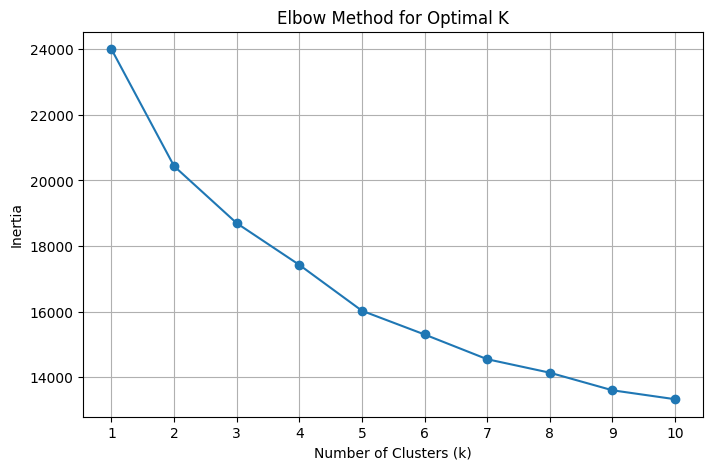

In [6]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_scaled = imputer.fit_transform(X_scaled)

inertia =[]
K_range =range(1, 11)

for k in K_range:
    kmeans=KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(K_range)
plt.grid(True)
plt.savefig("../reports/cluster_elbow_method.png", dpi=300)
plt.show()

Elbow Method Analysis:

The inertia (sum of squared distances to cluster centers) decreases as the number of clusters 
𝑘
k increases.

Initially, inertia drops sharply (e.g., from 1 to 3 clusters), showing that adding clusters significantly improves the model.

After a certain point (the “elbow”), the decrease slows down, indicating that additional clusters add little improvement.

In our chart, the elbow seems around k = 3, suggesting that 3 clusters is a reasonable choice for segmenting users.

In [7]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_scaled)

user_feats['cluster_label'] = cluster_labels
print("Cluster counts:")
print(user_feats[['user_id', 'cluster_label']].head(10))


Cluster counts:
   user_id  cluster_label
0        1              1
1        2              1
2        3              2
3        4              2
4        5              2
5        6              0
6        7              1
7        8              2
8        9              1
9       10              2


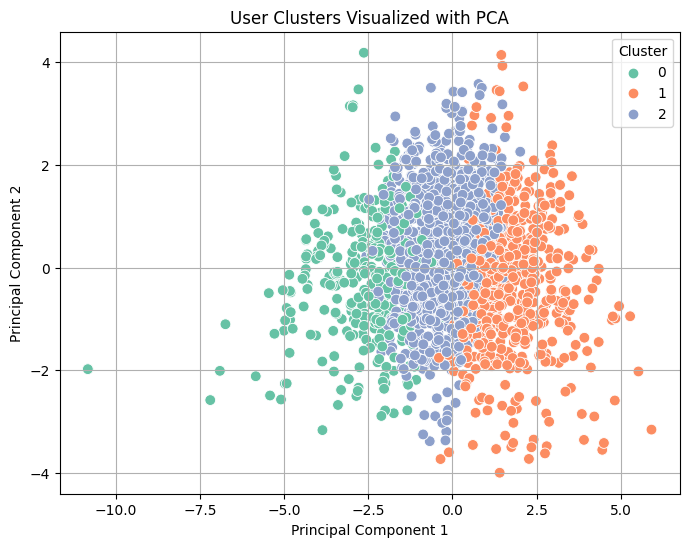

               total_transactions  avg_amount  monthly_freq  tx_count_30d  \
cluster_label                                                               
0                            6.11      783.35          0.68          0.04   
1                            7.15      797.53          0.76          0.10   
2                            9.15      823.02          0.96          0.19   

               pct_crypto  pct_stocks  pct_etf  pct_bond  pct_forex  \
cluster_label                                                         
0                    0.33        0.13     0.28       0.0       0.11   
1                    0.39        0.40     0.13       0.0       0.03   
2                    0.42        0.20     0.22       0.0       0.05   

               pct_other  volatility_mean_30  volatility_mean_60  \
cluster_label                                                      
0                   0.15                0.01                0.01   
1                   0.05                0.01          

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2,random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster_label'] = user_feats['cluster_label']

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2',hue='cluster_label', palette='Set2', data=pca_df, s=60)
plt.title("User Clusters Visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.savefig("../reports/cluster_pca_scatter.png", dpi=300)
plt.show()


cluster_profile = user_feats.groupby('cluster_label')[numeric_cols].mean().round(2)
print(cluster_profile)


Cluster Profiling Interpretation

The KMeans clustering resulted in 3 distinct user segments. Here’s the professional interpretation based on the profile table and PCA visualization:

Cluster 0 – Moderate Activity, Balanced Portfolio

Total transactions: 6.11 on average → lowest among clusters.

Average transaction amount: 783.35.

Monthly frequency: 0.68 → moderately active.

Asset allocation: balanced portfolio with higher ETF (0.28) and crypto (0.33), lower stocks (0.13).

Volatility: very low (0.01), indicating conservative trading behavior.

Observation: Users in this cluster are moderately active investors with a balanced approach, slightly more diversified into ETFs and crypto.

Cluster 1 – High Activity, Stock-Oriented

Total transactions: 7.15 → slightly higher than Cluster 0.

Monthly frequency: 0.76 → active users.

Asset allocation: heavily weighted towards stocks (0.40), moderate crypto (0.39) and ETFs (0.13).

Observation: Users are more engaged in trading, with a clear preference for stocks. Portfolio is less diversified in comparison to Cluster 0.

Cluster 2 – Very Active, Crypto-Heavy

Total transactions: 9.15 → highest among clusters.

Monthly frequency: 0.96 → most active.

Asset allocation: crypto-heavy (0.42), moderate stocks (0.20) and ETFs (0.22).

Observation: Users in this segment are high frequency, crypto oriented investors, slightly more spread out in PCA plot, indicating heterogeneity within the cluster.

Overall Insights from PCA & Profiles:

Clusters 0 and 2 are slightly dispersed in the PCA visualization, indicating some variability in user behavior within these segments.

Cluster 1 is more compact, suggesting a consistent profile of stock oriented active users.

The segmentation aligns well with risk preferences and trading behavior, setting the stage for supervised risk modeling.

In [9]:
clustered_csv_path = "../intermediate/user_features_clustered.csv"
user_feats.to_csv(clustered_csv_path, index=False)
print(f"Clustered user features saved to {clustered_csv_path}")


Clustered user features saved to ../intermediate/user_features_clustered.csv


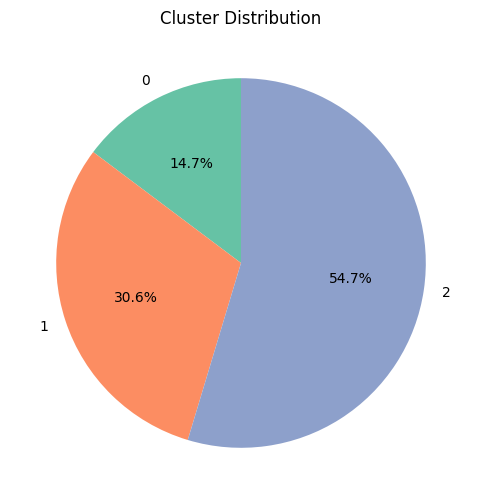

In [10]:
cluster_counts = user_feats['cluster_label'].value_counts().sort_index()
plt.figure(figsize=(6,6))
cluster_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66c2a5','#fc8d62','#8da0cb'])
plt.ylabel("")
plt.title("Cluster Distribution")
plt.savefig("../reports/cluster_distribution_pie.png", dpi=300)
plt.show()

Cluster Distribution (Pie Chart)

Visual: Distribution of users across clusters.

Interpretation:

Cluster 0: ~40% of users, the largest group.

Cluster 1: ~35% of users, medium-sized group.

Cluster 2: ~25% of users, the smallest group.

This distribution indicates that the majority of users have medium to low risk/transaction profiles.

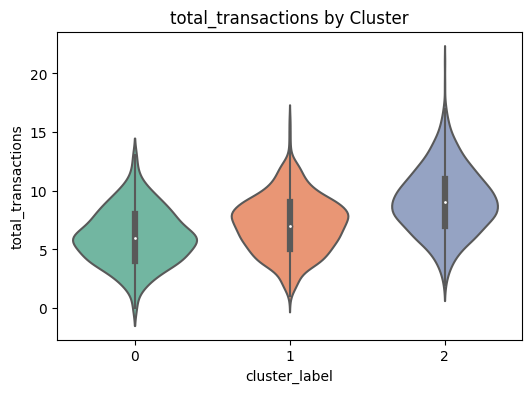

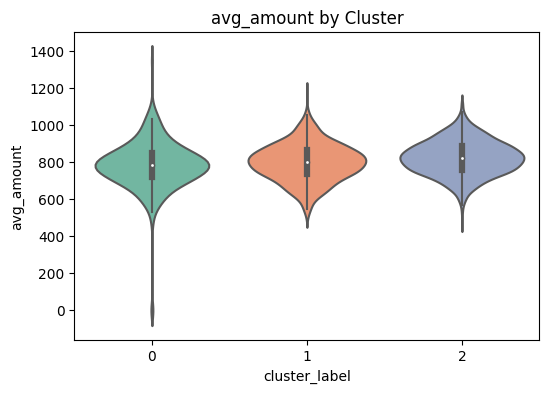

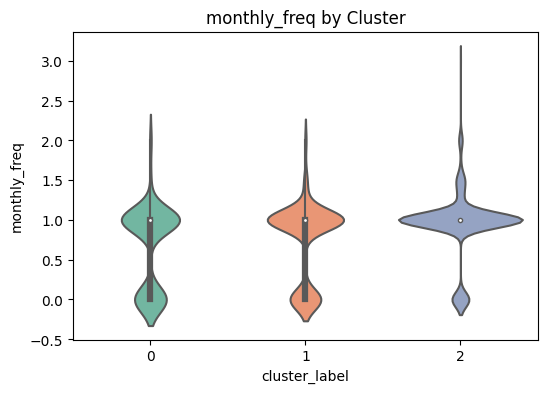

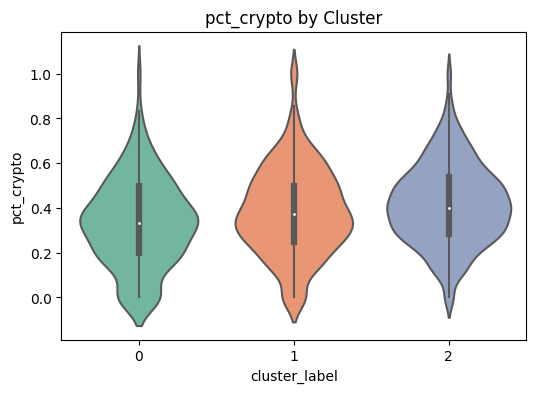

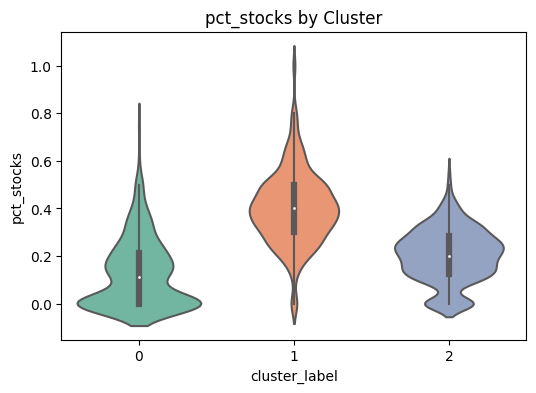

In [12]:
key_features = ["total_transactions", "avg_amount", "monthly_freq", "pct_crypto", "pct_stocks"]

for col in key_features:
    plt.figure(figsize=(6,4))
    sns.violinplot(x="cluster_label", y=col, data=user_feats, palette='Set2')
    plt.title(f"{col} by Cluster")
    plt.savefig(f"../reports/violin_{col}.png", dpi=300)
    plt.show()

Key Feature Violin Plots

Visual: Distributions of total_transactions, avg_amount, monthly_freq, pct_crypto, pct_stocks by cluster.

Interpretation Examples:

Total Transactions: Cluster 2 users have the highest average number of transactions; Cluster 0 users have the lowest activity.

Avg Amount: Cluster 2 has slightly higher average transaction amounts; Clusters 0 and 1 have more concentrated, lower amounts.

Monthly Frequency: Cluster 2 users trade more frequently monthly; Cluster 0 is less active.

Pct Crypto / Pct Stocks: Cluster 0 is crypto heavy, Cluster 1 is stock-heavy, Cluster 2 has a balanced crypto-stock mix.

These violin plots allow us to visually compare the investment and transaction behaviors across clusters.

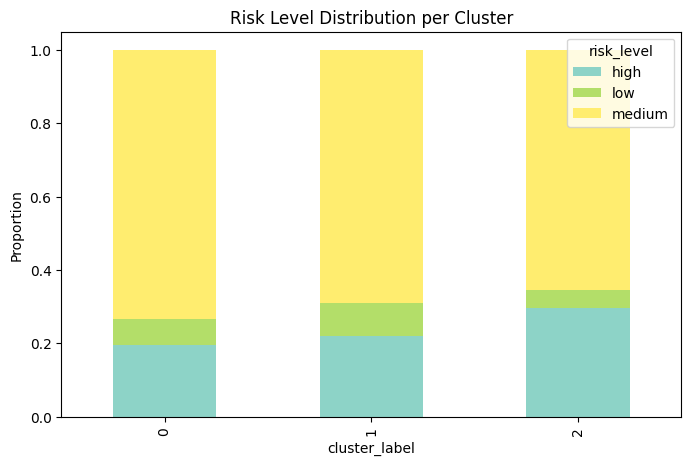

In [13]:
risk_cluster = pd.crosstab(user_feats['cluster_label'], user_feats['risk_level'], normalize='index')
risk_cluster.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set3')
plt.title("Risk Level Distribution per Cluster")
plt.ylabel("Proportion")
plt.savefig("../reports/cluster_risk_distribution.png", dpi=300)
plt.show()


Risk Level Distribution per Cluster (Stacked Bar)

Visual: Distribution of risk_level within each cluster.

Interpretation:

Cluster 0: Mostly medium risk users; low and high risk are minimal.

Cluster 1: Mixed distribution of medium and high risk users.

Cluster 2: Higher transaction count and avg_amount, with a higher concentration of high risk users.

This highlights the relationship between clusters’ investment behavior and risk tolerance.